# CMEMS OSTIA Marine Heatwave Time Series Plotter

    Version: 1.0
    Date:    27/09/2019
    Author:  Ben Loveday (Plymouth Marine Laboratory) and Hayley Evers-King (EUMETSAT)
    Credit:  This code was developed for EUMETSAT under contracts for the Copernicus 
             programme.
    License: This code is offered as open source and free-to-use in the public domain, 
             with no warranty.

**What is this notebook for?**

This notebook will plot marine heat wave analyses using the CMEMS OSTIA data.

**What specific tools does this notebook use?**

The marine heat wave tool kit *ocean-wekeo-jpyhub/Third_Party_Tools/marineHeatWaves-master*

***

Python is divided into a series of modules that each contain a series of methods for specific tasks. The box below imports all of the moduls we need to complete our plotting task

In [1]:
%matplotlib inline

# standard tools
import os
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import datetime
import warnings
warnings.filterwarnings('ignore')

# specific tools (which can be found here ../../Third_Party_Tools/)
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())) + '/Third_Party_Tools/marineHeatWaves-master/')
import marineHeatWaves as mhw

Next we will set a few parameters for making our plots and to tell the notebook where our data is

In [2]:
# where the data should have been downloaded to:
download_dir_path = "/home/jovyan/work/products/"

# subset image: cut a relevant section out of an image for area averaging. If false, whole area will be used.
# THERE IS NO AREA WEIGHTING IN THE AVERAGING HERE! 
# Subset_extents [lon1,lon2,lat1,lat2] describes the section we cut
subset_image = False
subset_extents = [-165.0, -145.0, 10.0, 30.0]

# The data product time is measured in seconds since the following refernce date
Date_ref = datetime.datetime(1981,1,1)

# Select the times we want to use for our spatial anomaly plots [month, day]
month_day_start = [8,1] 
month_day_end = [9,24]

# Plotting font size
fsz = 30

Next we find all of our data files. We do this by concatenating two lists, as there are two distinct file types.

In [3]:
SST_files = []
my_files = glob.glob(download_dir_path+'/METOFFICE-GLO-SST-L4-RAN*')
for SST_file in sorted(my_files):
    SST_files.append(SST_file)
    
my_files = glob.glob(download_dir_path+'/METOFFICE-GLO-SST-L4-NRT*')
for SST_file in sorted(my_files):
    SST_files.append(SST_file)

The next cell performs the bulk of the processing work for our plot. We start by loading in coordinates that we can use to subset the data (if required) and make our plots. Subsequently, we loop through the SST products and read in the data, correct Kelvin to Celsius and perform our averaging in either time and space.

In [4]:
#load the co-ordinate variables we need for subsetting/plotting
ds = xr.open_dataset(SST_files[-1])
lat = ds.lat.data
lon = ds.lon.data
ds.close()

# subset coords if required, getting indices to subset out output SST products
if subset_image:
    ii = np.where((lon >= subset_extents[0]) & (lon <= subset_extents[1]))[0]
    jj = np.where((lat >= subset_extents[2]) & (lat <= subset_extents[3]))[0]
    lon = lon[ii]
    lat = lat[jj]

# initialise lists for output times series variables for MWH    
all_times = []
all_SST = []

# initialise arrays for output SST fields
iter_SST = np.ones([len(SST_files), len(lat), len(lon)])*np.nan

# now we get the area-averaged data
count = -1
for SST_file in SST_files:
    print(SST_file)
    count = count + 1

    # xarray does not read times consistency between RAN and NRT, so we load as integer
    ds = xr.open_dataset(SST_file, decode_times=False)
    this_SST = ds.analysed_sst.data
    times = ds.time.data
    ds.close()

    my_times = []
    for time in times:
        my_times.append(Date_ref + datetime.timedelta(seconds=int(time)))
    times = np.asarray(my_times)
    
    t0 = datetime.datetime(times[0].year, month_day_start[0], month_day_start[1])
    t1 = datetime.datetime(times[0].year, month_day_end[0], month_day_end[1])
    tt = np.where((times >= t0) & (times <= t1))[0]

    if np.nanmean(this_SST) > 100:
        this_SST = this_SST - 273.15

    if subset_image:
        this_SST = this_SST[:,jj[0]:jj[-1],ii[0]:ii[-1]]
    
    time_subset_SST = this_SST[tt,:,:]

    iter_SST[count,:,:] = np.squeeze(np.nanmean(time_subset_SST, axis=0))

    all_times.append(my_times)
    all_SST.append(np.nanmean(np.nanmean(this_SST, axis=1), axis=1))

/home/jovyan/work/products/METOFFICE-GLO-SST-L4-RAN-OBS-SST_19880101_19881231.nc
/home/jovyan/work/products/METOFFICE-GLO-SST-L4-RAN-OBS-SST_19890101_19891231.nc
/home/jovyan/work/products/METOFFICE-GLO-SST-L4-RAN-OBS-SST_19900101_19901231.nc
/home/jovyan/work/products/METOFFICE-GLO-SST-L4-RAN-OBS-SST_19910101_19911231.nc
/home/jovyan/work/products/METOFFICE-GLO-SST-L4-RAN-OBS-SST_19920101_19921231.nc
/home/jovyan/work/products/METOFFICE-GLO-SST-L4-RAN-OBS-SST_19930101_19931231.nc
/home/jovyan/work/products/METOFFICE-GLO-SST-L4-RAN-OBS-SST_19940101_19941231.nc
/home/jovyan/work/products/METOFFICE-GLO-SST-L4-RAN-OBS-SST_19950101_19951231.nc
/home/jovyan/work/products/METOFFICE-GLO-SST-L4-RAN-OBS-SST_19960101_19961231.nc
/home/jovyan/work/products/METOFFICE-GLO-SST-L4-RAN-OBS-SST_19970101_19971231.nc
/home/jovyan/work/products/METOFFICE-GLO-SST-L4-RAN-OBS-SST_19980101_19981231.nc
/home/jovyan/work/products/METOFFICE-GLO-SST-L4-RAN-OBS-SST_19990101_19991231.nc
/home/jovyan/work/products/M

We need to do a little bit of processing of our data to get it in the right format for the marine heat wave toolkit

In [5]:
# flatten the SST list
SST_time_series = [item for sublist in all_SST for item in sublist]
SST_time_series = np.asarray(SST_time_series)

# format the dates for the MWH toolkit
Dates_time_series = [item for sublist in all_times for item in sublist]
Dates_time_series_formatted = [datetime.date.toordinal(tt) for tt in Dates_time_series]

We take an average of our SST time block (iter_SST) to get a climatology and then calculate the marine heat wave products

In [6]:
# make climatology of time subset region
clim_SST = np.nanmean(iter_SST, axis=0)

# calculate heat waves
mhws, clim = mhw.detect(np.asarray(Dates_time_series_formatted), SST_time_series)

Now we have all of our data, we will make the marine heat wave plot

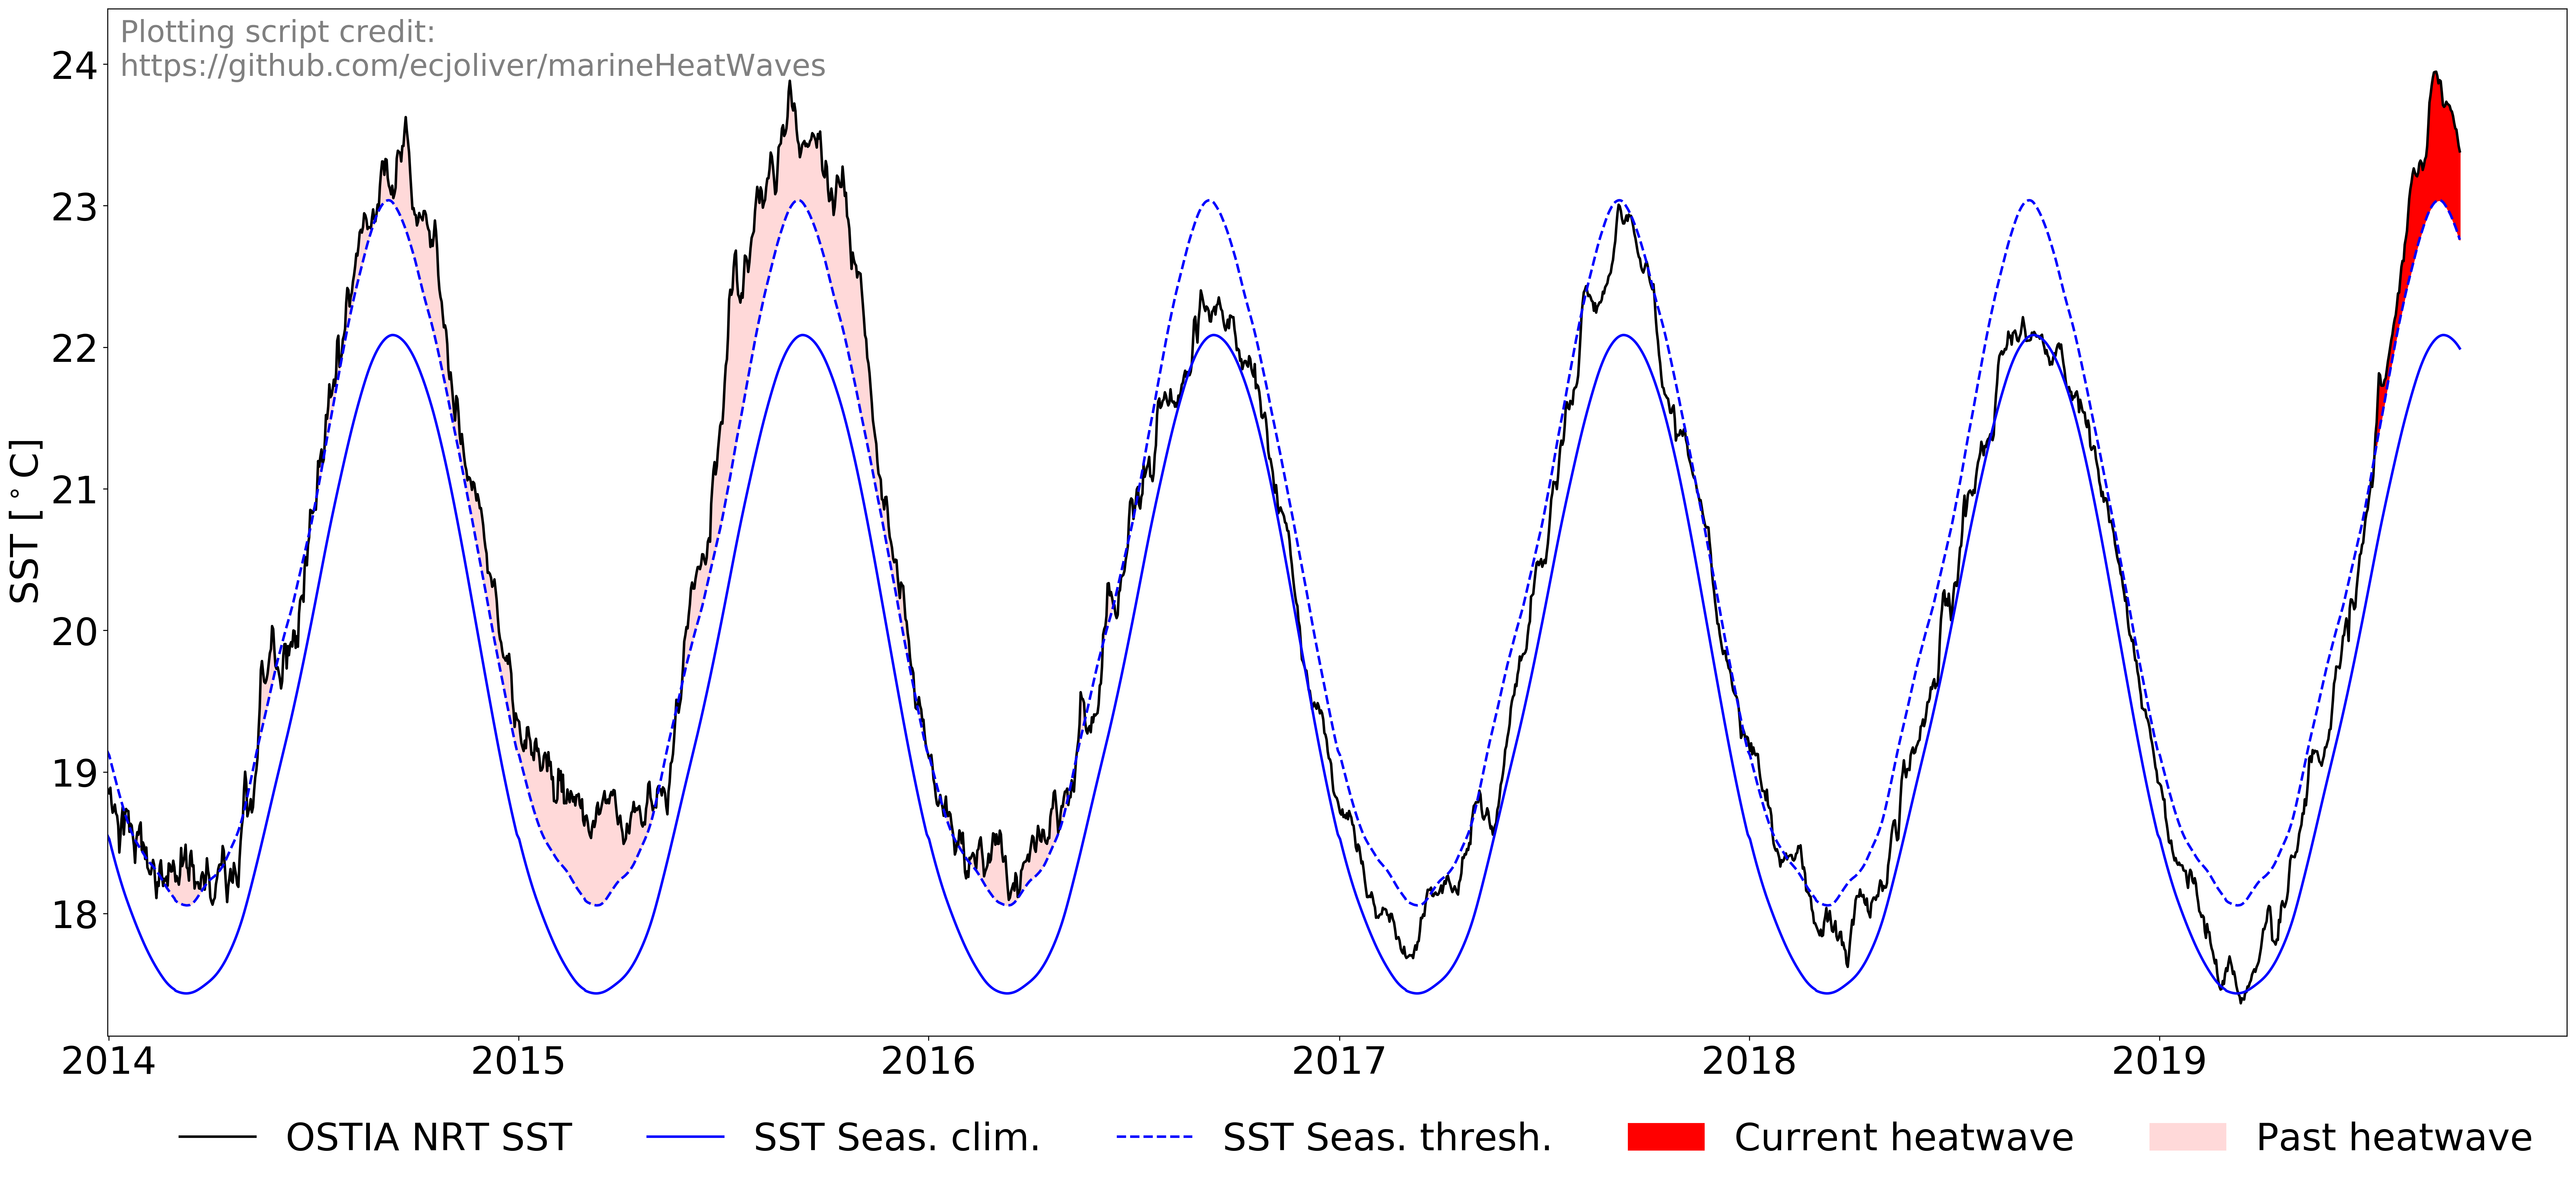

In [11]:
# plot MWHs
ev = np.argmax(mhws['intensity_max']) # Find largest event

fig = plt.figure(figsize=(35,15), dpi = 300)
plt.rc('font', size=fsz)

# Find indices for all n MHWs before and after event of interest and shade accordingly
n=10
for ev0 in np.arange(ev-n, ev+n, 1):
    t1 = np.where(Dates_time_series_formatted==mhws['time_start'][ev0])[0][0]
    t2 = np.where(Dates_time_series_formatted==mhws['time_end'][ev0])[0][0]
    p1 = plt.fill_between(Dates_time_series[t1:t2+1], SST_time_series[t1:t2+1],\
                          clim['thresh'][t1:t2+1], color=(1,0.85,0.85))
    
# Find indices for MHW of interest and shade accordingly
t1 = np.where(Dates_time_series_formatted==mhws['time_start'][-1])[0][0]
t2 = np.where(Dates_time_series_formatted==mhws['time_end'][-1])[0][0]
p2 = plt.fill_between(Dates_time_series[t1:t2+1], SST_time_series[t1:t2+1],\
                      clim['thresh'][t1:t2+1], color='r')

# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
p3, = plt.plot(Dates_time_series, SST_time_series, 'k-', linewidth=2)
p4, = plt.plot(Dates_time_series, clim['thresh'], 'b--', linewidth=2)
p5, = plt.plot(Dates_time_series, clim['seas'], 'b-', linewidth=2)

xmin = datetime.datetime(2014,1,1).toordinal() - datetime.datetime(1,1,1).toordinal()
xmax = datetime.datetime(2019,12,31).toordinal() - datetime.datetime(1,1,1).toordinal()
plt.xlim(xmin,xmax)

plt.ylim(clim['seas'].min() - 0.3, clim['seas'].max() + mhws['intensity_max'][ev] + 0.2)
plt.ylabel('SST [$^\circ$C]')
plt.annotate('Plotting script credit:\nhttps://github.com/ecjoliver/marineHeatWaves',\
             (0.005, 0.935), xycoords='axes fraction', color='0.5', fontsize=fsz/1.25)

leg = plt.legend([p3, p5, p4, p2, p1],\
                 ['OSTIA NRT SST','SST Seas. clim.','SST Seas. thresh.','Current heatwave','Past heatwave'],\
                 bbox_to_anchor=(1.0, -0.05), ncol=5)

leg.get_frame().set_linewidth(0.0)
plt.savefig('MHW.png')

Finally, we calculate the SST anomaly by subtracting the climatology

In [8]:
# make matrix
stripe_array = np.ones([20,len(SST_files)])*np.nan

# now make the anomaly
for ii in range(len(SST_files)):
    stripe_array[:, ii] = np.nanmean(np.squeeze(iter_SST[ii,:,:]) - clim_SST)

......and plot our climate "stripes"

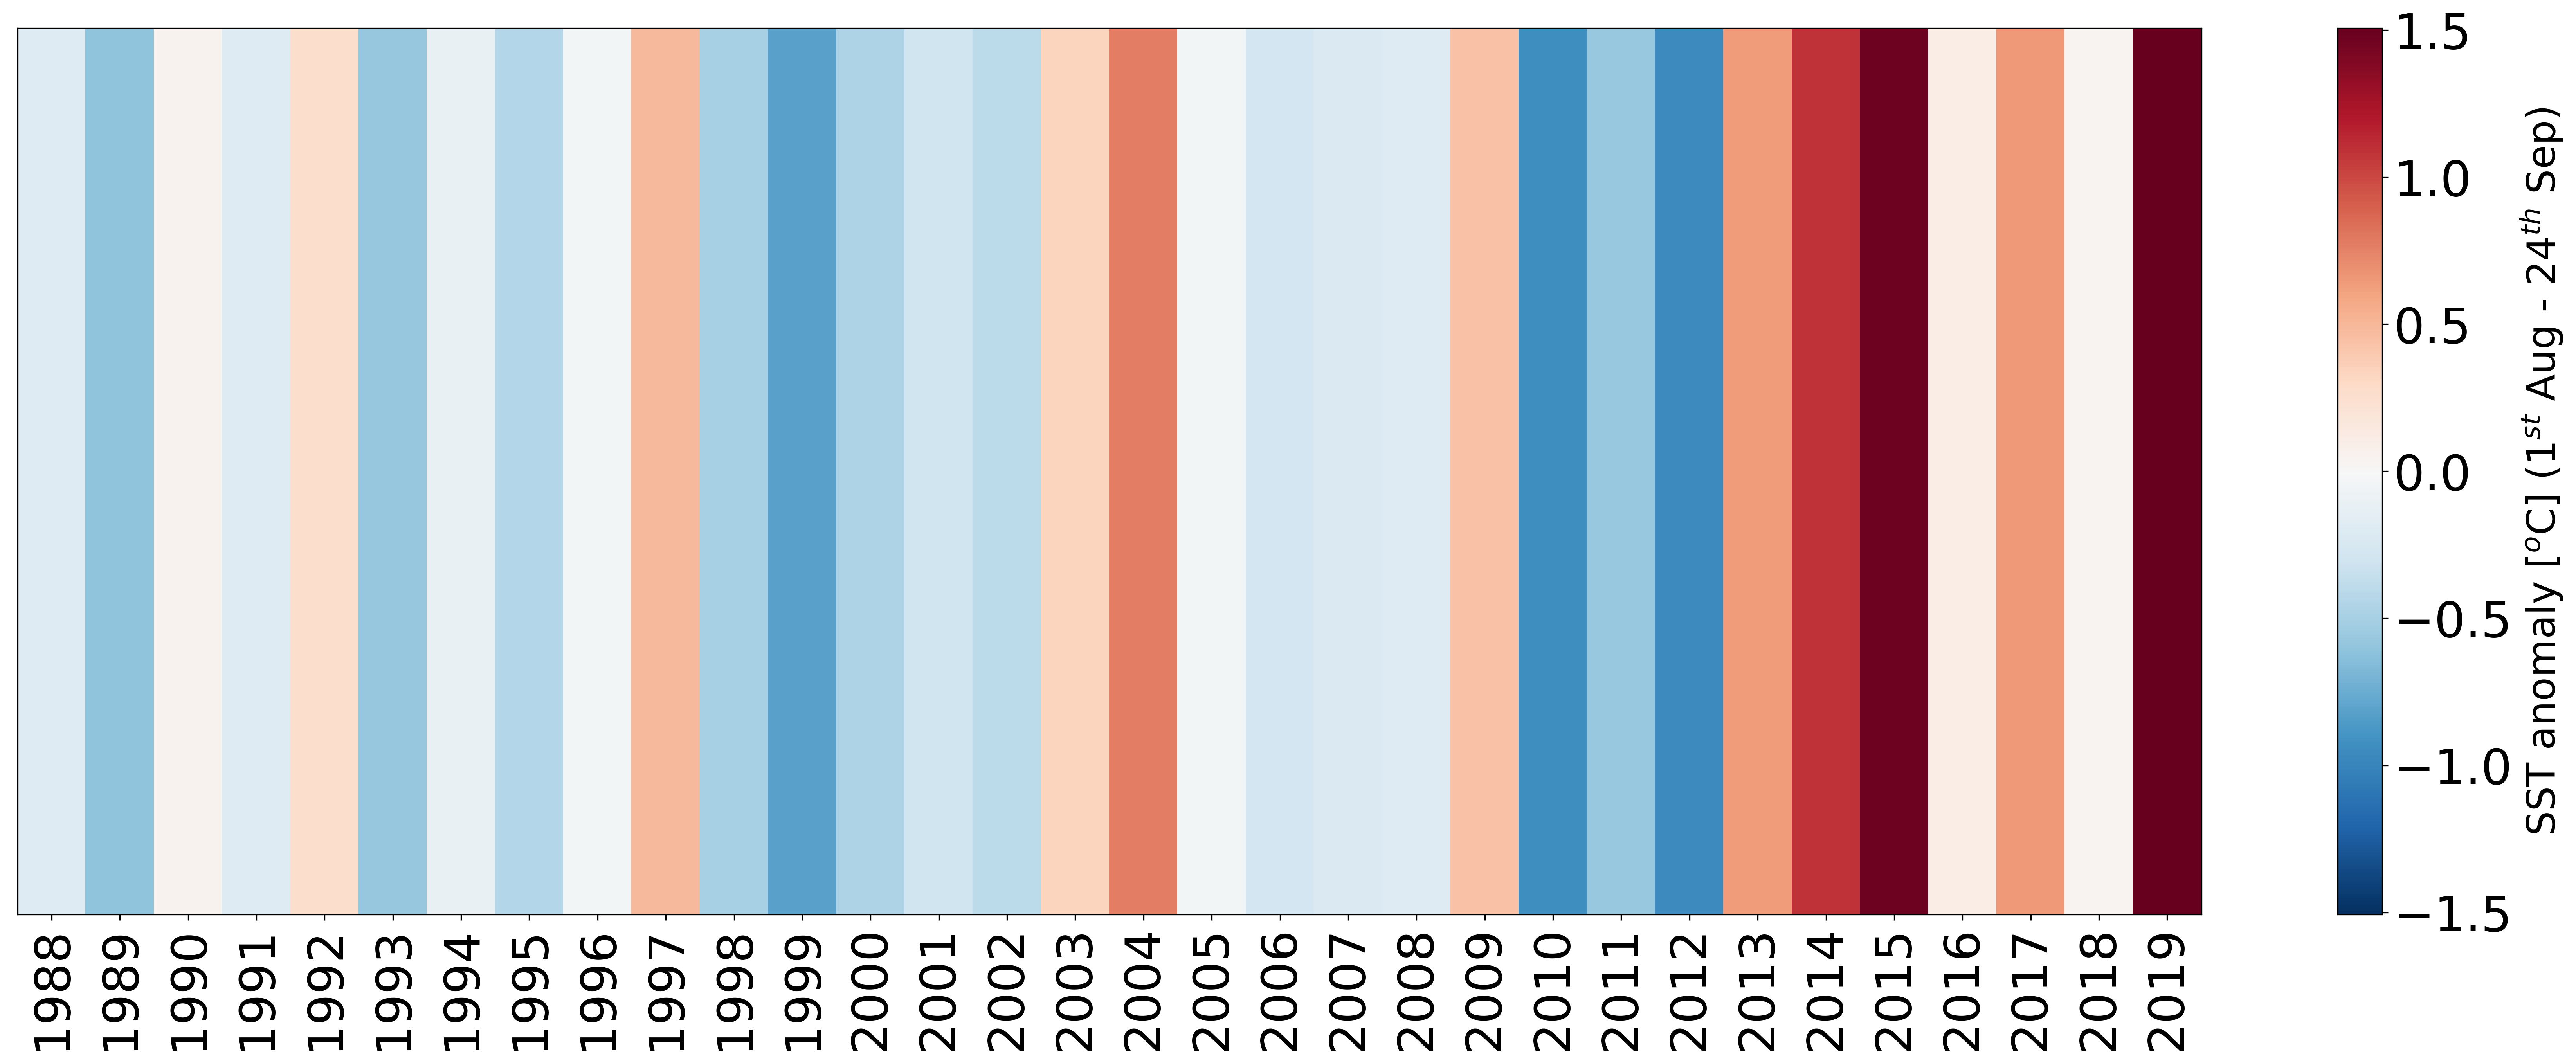

In [9]:
fig = plt.figure(figsize=(30,10), dpi =300)
vmax = np.nanmax(abs(stripe_array))

date_ticks = []
for ii in range(len(SST_files)):
    date_ticks.append(str(1988+ii))
    
plt.pcolormesh(stripe_array,vmin=vmax*-1,vmax=vmax,cmap=plt.cm.RdBu_r)
plt.xticks(np.arange(len(SST_files))+0.5,date_ticks, rotation='90')
plt.yticks([],[])
cbar = plt.colorbar()
cbar.set_label('SST anomaly [$^{o}$C] (1$^{st}$ Aug - 24$^{th}$ Sep)',fontsize=fsz/1.25)
plt.savefig('Stripes.png')